In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras_applications catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from keras.applications.resnet import ResNet50
from PIL import Image
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [ ]:
resnet_ = ResNet50(weights='imagenet',classes=1000)

102967424/102967424 [==============================] - 0s 0us/step


In [2]:
dir = '/content/drive/MyDrive/dataset'
test_path = pd.read_csv('/Users/samedi/Downloads/train_dataset_Минприроды/test.csv')
train_path = pd.read_csv('/Users/samedi/Downloads/train_dataset_Минприроды/train.csv')

In [ ]:
len(os.listdir(dir+"/shipun/images"))+len(os.listdir(dir+"/maliy/images"))+len(os.listdir(dir+"/klikun/images"))

9038

In [ ]:
def get_spath(savedir, row_path):
    prepath = row_path['path_img'].replace('images\\','').replace('\\','/')
    prepath = prepath.replace('.jpg','_id'+str(row_path['obj_id'])+'.jpg')
    return os.path.join(savedir, prepath)

In [ ]:
def preprocess(paths, savedir):
    SIZE = (224, 224)
    for i, row_path in paths.iterrows():
        path = os.path.join(dir,row_path['path_img'].replace('\\','/'))
        spath = get_spath(savedir, row_path)
        
        if not os.path.exists(spath):
            img = Image.open(path).convert('RGB')
            img = img.crop((row_path['x1'],row_path['y1'],row_path['x2'],row_path['y2']))
            img = img.resize(SIZE, Image.ANTIALIAS)
            img.save(spath)

        if i%300==299:
            print(i/len(paths.index)*100)

In [ ]:

def extract_batch(paths, dir, batch):
    x = np.ndarray(shape=(batch, 224, 224, 3))
    for i, row_path in paths.iterrows():
        path = get_spath(dir, row_path)
        img = Image.open(path)
        x[i] = np.asarray(img)
    features = resnet_.predict(x, workers=-1)
    df = pd.DataFrame(features)
    df['target'] = paths['type_id']
    return df

def extract(paths, dir, batch=100):
    dfs = []
    N = int(len(paths.index)/batch)
    for i in range(N):
        dfs.append(extract_batch(paths.iloc[i*batch:(i+1)*batch],dir,batch))
        print(str(i/N*100))
    r = len(paths.index)%batch
    if r != 0:
        dfs.append(extract_batch(paths.iloc[len(paths.index)-r:],dir,r))
    return pd.concat(dfs)

In [ ]:
preprocess(train_path,'/content/drive/MyDrive/dataset_crop/train')
preprocess(test_path,'/content/drive/MyDrive/dataset_crop/test')

2.4956180619313915
4.999582672564895
7.503547283198397
10.007511893831902
12.511476504465405
15.015441115098907
17.51940572573241
20.02337033636591
22.527334946999417
25.03129955763292
27.535264168266423
30.039228778899922
32.54319338953343
35.04715800016693
37.551122610800434
40.055087221433936
42.55905183206744
45.06301644270094
47.566981053334445
50.07094566396795
52.57491027460145
55.07887488523495
57.582839495868456
60.08680410650196
62.59076871713547
65.09473332776898
67.59869793840248
70.10266254903598
72.60662715966947
75.11059177030297
77.61455638093648
80.11852099156998
82.62248560220348
85.12645021283699
87.63041482347049
90.13437943410399
92.6383440447375
95.142308655371
97.6462732660045
14.130434782608695
28.30812854442344
42.485822306238184
56.663516068052935
70.84120982986768
85.01890359168242
99.19659735349717


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/dataset_crop/train/klikun')))
print(len(os.listdir('/content/drive/MyDrive/dataset_crop/train/shipun')))
print(len(os.listdir('/content/drive/MyDrive/dataset_crop/train/maliy')))

12341

In [ ]:
len(train_path.index)

11981

In [ ]:
train = extract(train_path,'/content/drive/MyDrive/dataset_crop/train')
test = extract(test_path,'/content/drive/MyDrive/dataset_crop/test')
train.head()

FileNotFoundError: ignored

In [17]:
train = pd.read_csv('/Users/samedi/Downloads/train_dataset_Минприроды/train_ml.csv').drop(columns=['Unnamed: 0'])
test = pd.read_csv('/Users/samedi/Downloads/train_dataset_Минприроды/test_ml.csv').drop(columns=['Unnamed: 0'])

In [18]:
X_train = train.drop(columns=['target'])
X_test = test.drop(columns=['target'])
y_train = pd.DataFrame({'target':train_path['type_id']})
y_test = pd.DataFrame({'target':test_path['type_id']})

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 200)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_train, y_train)
print('train score',logit_searcher.score(X_train, y_train))
print('valid score',logit_searcher.score(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s


KeyboardInterrupt: 

## Результат логистической регрессии

In [26]:

print('train score',logit_searcher.score(X_train, y_train))
print('valid score',logit_searcher.score(X_test, y_test))

train score 0.5811701861280361
valid score 0.5340264650283554


In [20]:
model = CatBoostClassifier(
    iterations=150,
    random_seed=43,
    loss_function='MultiClass'
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Результат КэтБуста

In [21]:
model.score(X_test, y_test)

0.7159735349716446

In [3]:
master_path = 'images/1958951077.jpg'
master_img = Image.open(
    '/Users/samedi/Downloads/train_dataset_Минприроды/maliy/images/1958951077.jpg')
path_df = pd.read_csv('/Users/samedi/Downloads/all_annotation.csv')
path_df.head()


,frame_id,type_name,type_id,obj_id,path_img,path_mask,x1,y1,x2,y2,height,width
0,0,klikun,0,0,images\1.jpg,masks\1.png,0,348,985,1364,1365,2048
1,1,klikun,0,1,images\1.jpg,masks\1.png,0,889,94,989,1365,2048
2,2,klikun,0,2,images\1.jpg,masks\1.png,63,666,205,1099,1365,2048
3,3,klikun,0,3,images\1.jpg,masks\1.png,971,730,1426,1269,1365,2048
4,4,klikun,0,4,images\1.jpg,masks\1.png,1474,474,2047,1364,1365,2048


In [5]:
sup_ids = path_df[path_df['path_img']==master_path.replace('/','\\')]['obj_id']
sup_ids.head()

5389    0
5390    1
5391    2
5392    3
Name: obj_id, dtype: int64

In [12]:
imgs = []
for ind, row in sup_ids.iteritems():
    imgs.append(np.asarray(Image.open(os.path.join('/Users/samedi/Downloads/train','maliy','1958951077_id'+str(row)+'.jpg'))))

/var/folders/1j/52ghjy5x1v13yrj1b6fgwlcc0000gn/T/ipykernel_36056/3815903073.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ind, row in sup_ids.iteritems():


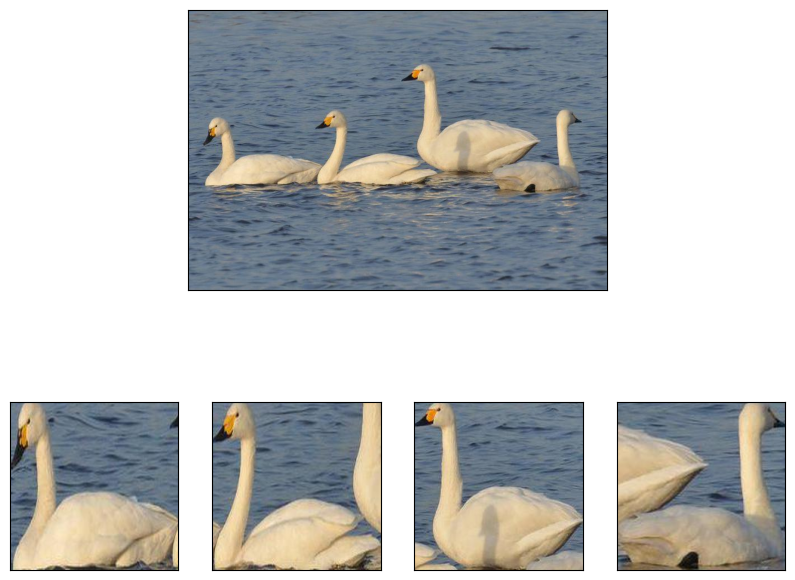

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.imshow(np.asarray(master_img))
plt.tick_params('both',which='both',left=False,right=False,top=False,bottom=False,labelbottom=False,labelleft=False)

plt.subplot(245)
plt.imshow(imgs[0])
plt.tick_params('both',which='both',left=False,right=False,top=False,bottom=False,labelbottom=False,labelleft=False)

plt.subplot(246)
plt.imshow(imgs[1])
plt.tick_params('both',which='both',left=False,right=False,top=False,bottom=False,labelbottom=False,labelleft=False)

plt.subplot(247)
plt.imshow(imgs[2])
plt.tick_params('both',which='both',left=False,right=False,top=False,bottom=False,labelbottom=False,labelleft=False)

plt.subplot(248)
plt.imshow(imgs[3])
plt.tick_params('both',which='both',left=False,right=False,top=False,bottom=False,labelbottom=False,labelleft=False)
